In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
import pandas as pd

import sys 
sys.path.append('../python')

from auxiliary import get_base_network_name

import seaborn as sns
from mpl_settings_v3 import *
%matplotlib inline

from plot_auxiliary import *

net_dir = '../networks/ER'

def load_dataframe(attack, size, param, net_type='ER', fast=False, n_seeds=None):
    dir_name = os.path.join('../networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    base_csv_file_name = '{}_nSeeds{:d}_cpp.csv'.format(attack, n_seeds)
    csv_file_name = os.path.join(dir_name, base_net_name, base_net_name_size, base_csv_file_name)
    df = pd.read_csv(csv_file_name, index_col=0)
    return df

In [3]:
def Pk_ER(kmax, c):
    """
    Complementary cumulative distribution function for 
    the Poisson distribution.
    """
    
    s = 0
    for k in range(kmax):
        s += pk(k, c)
    return 1 - s

def pk_ER(k, c):
    """
    Poisson degree distribution.
    """
    return np.exp(-c) * c**k / np.math.factorial(k)

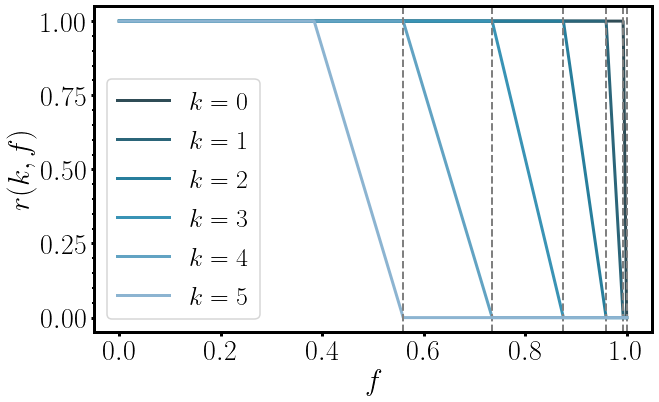

In [4]:
## Erdos-Renyi

Pk = Pk_ER
pk = pk_ER

def rk(k, c, f):
    """
    Threshold for continuos f that depends only on the 
    node degree.
    """
    
    if f < Pk(k+1, c):
        return 1
    elif f >= Pk(k, c):
        return 0
    return (Pk(k, c)-f)/pk(k, c)

c = 5
f_values = np.linspace(0, 1, 1000)

palette = sns.color_palette("PuBuGn_d")[::-1]
fig, ax = plt.subplots(figsize=(10, 6))

for i, k in enumerate(range(6)):
    rk_values = [rk(k, c, f) for f in f_values]
    ax.plot(f_values, rk_values, color=palette[i], label=r'$k = {{{}}}$'.format(k))
    ax.axvline(Pk(k, c), color='grey', linestyle='--', linewidth=2)
ax.set_xlabel(r'$f$')
ax.set_ylabel(r'$r(k, f)$')
ax.legend()
plt.show()

In [31]:
def F0(x, c, f):
    """
    Generating function for the degree distribution
    for an initial degree attack with continuos f.
    """
    
    s = 0
    k = 0
    while True:
        pk_rk_value = pk(k, c) * rk(k, c, f)
        if pk_rk_value == 0:
            break
        s +=  pk_rk_value * x**k
        k += 1
    return s   

def F1(x, c, f):
    """
    Generating function for the excess degree distribution
    for an initial degree attack with continuos f.
    """
    
    s = 0
    k = 0
    while True:
        pk_rk_value = pk(k, c) * rk(k, c, f)
        if pk_rk_value == 0:
            break
        s += k * pk_rk_value * x**(k-1)
        k += 1
    return s / c

def F1_prime(x, c, f):
    """
    Derivative of F1.
    """
    
    s = 0
    k = 0
    while True:
        pk_rk_value = pk(k, c) * rk(k, c, f)
        if pk_rk_value == 0:
            break
        s += k * (k-1) * pk_rk_value * x**(k-2)
        k += 1
    return s / c


def func(x, c, f):
    return 1 - F1(1, c, f) + F1(x, c, f) - x

def func_prime(x, c, f):
    return F1_prime(x, c, f) - 1

c = 5
n_values = 199
kmax_values = np.arange(n_values)
S_values = np.zeros(n_values)
meanS_values = np.zeros(n_values)

f_values = np.linspace(0.01, 0.8, n_values)
F1_prime_values = np.zeros(n_values)
for i, f in enumerate(f_values):

    sol = root_scalar(func, args=(c, f), fprime=func_prime, x0=0.5, method='newton')
    u = sol.root
    S = F0(1, c, f) - F0(u, c, f)
    S_values[i] = S

    meanS = (F0(u, c, f) + c*F1(u, c, f)*F1(u, c, f))/((1-S)*(1-F1_prime(u, c, f)))
    meanS_values[i] = meanS
    
    F1_prime_values[i] = F1_prime(u, c, f)
    
    
## Critical point

def func_fc(x, c):
    return F1_prime(1, c, x) - 1

sol = root_scalar(func_fc, args=(c), fprime=func_prime, x0=0.5, x1=0.4, method='secant')
fc = sol.root

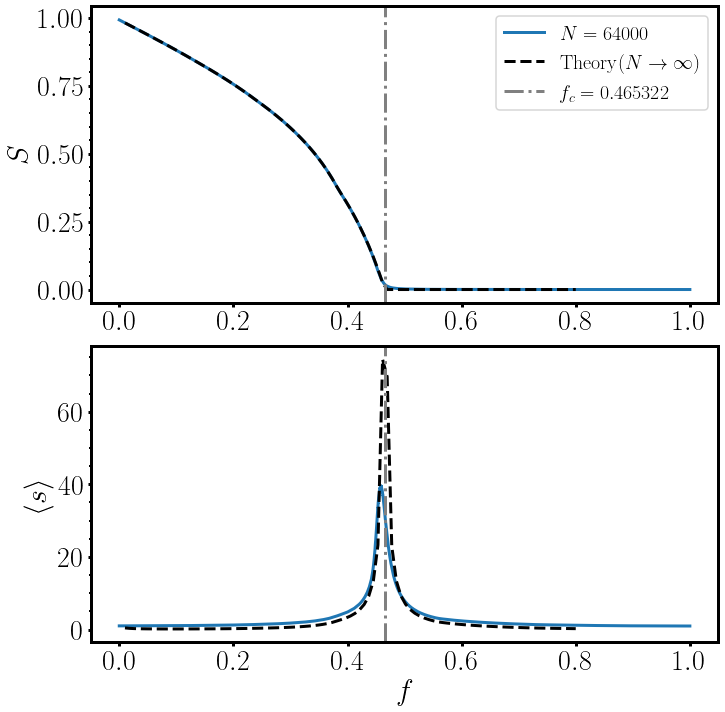

In [6]:
n_seeds = 10000
meank = 5
N = 64000

attack = 'Deg'
df = load_dataframe(attack, N, meank, fast=True, n_seeds=n_seeds)

fig, axes = plt.subplots(figsize=(10,10), nrows=2)

ax = axes[0]
ax.set_ylabel(r'$S$')
ax.plot(df.f, df.Sgcc, label=r'$N = {{{}}}$'.format(N))
ax.plot(f_values, S_values, '--', color='k', label=r'$\mathrm{Theory }(N\rightarrow \infty)$')
ax.axvline(fc, linestyle='-.', color='grey', label=r'$f_c = {{{:.6f}}}$'.format(fc))
ax.legend(loc='best', fontsize=20)

ax = axes[1]
ax.set_xlabel(r'$f$')
ax.set_ylabel(r'$\langle s \rangle$')
ax.plot(df.f, df.meanS)
ax.plot(f_values, meanS_values, '--', color='k')
ax.axvline(fc, linestyle='-.', color='grey')

plt.tight_layout()
plt.show()

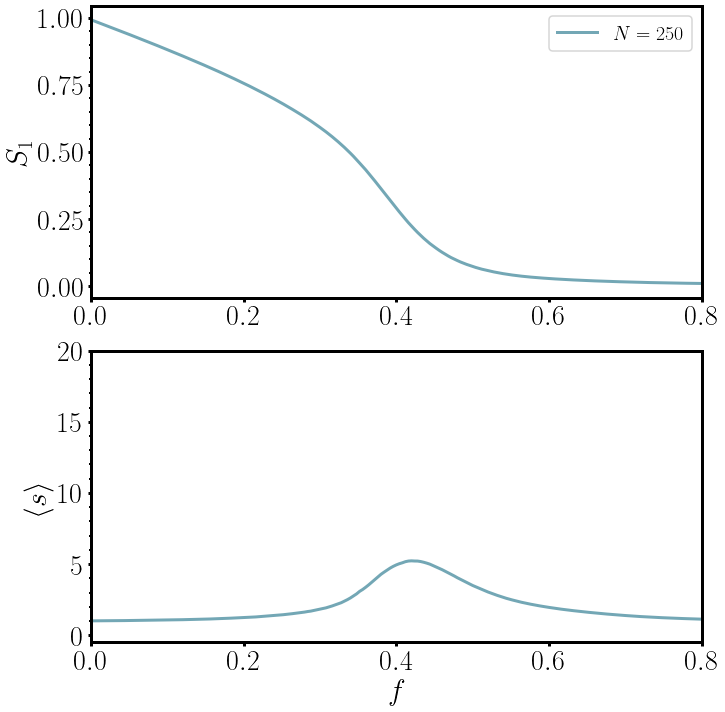

In [51]:
n_seeds = 10000
meank = 5
attack = 'Deg'
N_values = [
    #125,
    250, 
    #1000, 
    #4000,
    #8000,
    #16000,
    #32000
]

colormap = sns.cubehelix_palette(
    len(N_values), start=2, rot=0.3, light=0.6, dark=0.1
)

fig, axes = plt.subplots(figsize=(10,10), nrows=2)

for ax in axes:
    ax.set_xlim(0, 0.8)

ax = axes[0]
ax.set_ylabel(r'$S_1$')
for i, N in enumerate(N_values):
    df = load_dataframe(attack, N, meank, fast=True, n_seeds=n_seeds)
    ax.plot(
        df.f, df.Sgcc, color=colormap[i],
        label=r'$N = {{{}}}$'.format(N)
    )
#ax.plot(f_values, S_values, ':', color='k', label=r'$N\rightarrow \infty$')
#ax.axvline(fc, linestyle='-.', color='grey', label=r'$f_c = {{{:.6f}}}$'.format(fc))
ax.legend(loc='best', fontsize=20)

ax = axes[1]
ax.set_xlabel(r'$f$')
ax.set_ylabel(r'$\langle s \rangle$')
for i, N in enumerate(N_values):
    df = load_dataframe(attack, N, meank, fast=True, n_seeds=n_seeds)
    ax.plot(df.f, df.meanS, color=colormap[i])
#ax.plot(f_values, meanS_values, '--', color='k')
#ax.axvline(fc, linestyle='-.', color='grey')
ax.set_ylim(-0.5, 20)

plt.tight_layout()
plt.savefig(f'../seminario/n_finito_{N_values[-1]}.png')
plt.show()

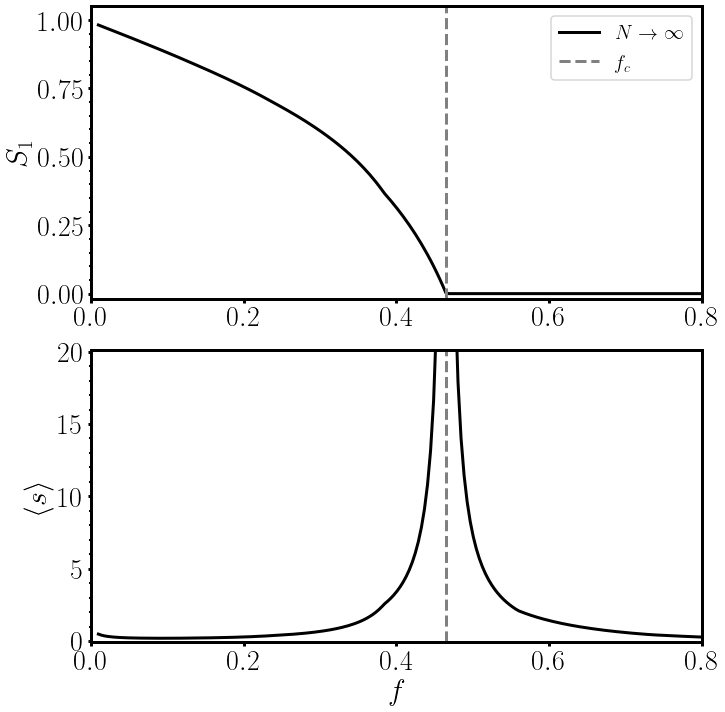

In [48]:
n_seeds = 10000
meank = 5
attack = 'Deg'
N_values = [
    #125,
    250, 
    1000, 
    #4000,
    8000,
    #16000,
    #32000
]

colormap = sns.cubehelix_palette(
    len(N_values), start=2, rot=0.3, light=0.6, dark=0.1
)

fig, axes = plt.subplots(figsize=(10,10), nrows=2)

for ax in axes:
    ax.set_xlim(0, 0.8)

ax = axes[0]
ax.set_ylabel(r'$S_1$')
ax.plot(f_values, S_values, '-', color='k', label=r'$N\rightarrow \infty$')
ax.axvline(fc, linestyle='--', color='grey', label=r'$f_c$')
ax.legend(loc='best', fontsize=20)
ax.set_ylim(-0.02, 1.05)

ax = axes[1]
ax.set_xlabel(r'$f$')
ax.set_ylabel(r'$\langle s \rangle$')
ax.plot(f_values, meanS_values, '-', color='k')
ax.axvline(fc, linestyle='--', color='grey')
ax.set_ylim(-.1, 1.05*df.meanS.max())
plt.tight_layout()
plt.savefig('../seminario/n_infinito.png')
plt.show()

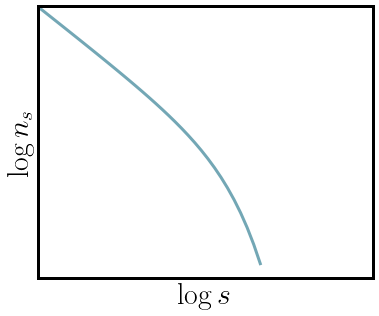

In [68]:
def powerlaw(x, a, c):
    return c*x**a

def truncated_powerlaw(x, a, c, b):
    return c*x**a * np.exp(-x/b)

colormap = sns.cubehelix_palette(
    4, start=2, rot=0.3, light=0.6, dark=0.1
)

X = np.logspace(1, 5)
Y = powerlaw(X, -1, 1)
Y1 = truncated_powerlaw(X, -1, 1, 2000)
Y2 = truncated_powerlaw(X, -1, 1, 10000)
Y3 = truncated_powerlaw(X, -1, 1, 100000)
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_ylim(5e-6, 1e-1)
ax.set_xlim(X[0], 1.5*X[-1])
ax.plot(X[:-15], Y1[:-15], '-', color=colormap[0])
#ax.plot(X[:-9], Y2[:-9], '-', color=colormap[1])
#ax.plot(X[:-2], Y3[:-2], '-', color=colormap[2])
#ax.plot(X, Y, '--', color='k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r'$\log s$')
ax.set_ylabel(r'$\log n_s$')

plt.savefig('../seminario/ns_finito_1.png')
plt.show()

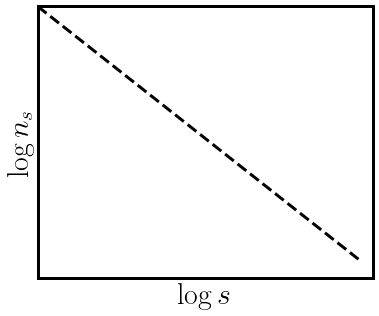

In [65]:
def powerlaw(x, a, c):
    return c*x**a

def truncated_powerlaw(x, a, c, b):
    return c*x**a * np.exp(-x/b)

colormap = sns.cubehelix_palette(
    4, start=2, rot=0.3, light=0.6, dark=0.1
)

X = np.logspace(1, 5)
Y = powerlaw(X, -1, 1)
Y1 = truncated_powerlaw(X, -1, 1, 2000)
Y2 = truncated_powerlaw(X, -1, 1, 10000)
Y3 = truncated_powerlaw(X, -1, 1, 100000)
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_ylim(5e-6, 1e-1)
ax.set_xlim(X[0], 1.5*X[-1])
ax.plot(X, Y, '--', color='k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r'$\log s$')
ax.set_ylabel(r'$\log n_s$')

plt.savefig('../seminario/ns_infinito_3.png')
plt.show()

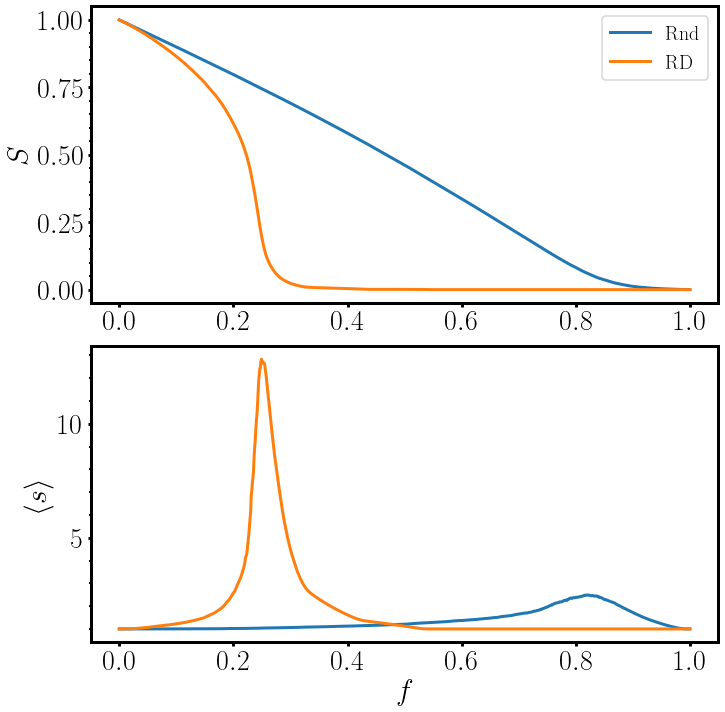

In [78]:
n_seeds = 1000
m = 3
N = 1000

attacks = [
    'Ran', 
    #'Deg', 
    'DegU', 
    #'CI', 'CIU'
]

fig, axes = plt.subplots(figsize=(10,10), nrows=2)

networks = [('ER', '3.00'), ('BA', 3)]
    
ax = axes[0]
ax.set_ylabel(r'$S$')
for attack in attacks:
    df = load_dataframe(attack, N, param, net_type, fast=True, n_seeds=n_seeds)
    ax.plot(df.f, df.Sgcc, label=attack_dict[attack])
ax.legend(loc='best', fontsize=20)

ax = axes[1]
ax.set_xlabel(r'$f$')
ax.set_ylabel(r'$\langle s \rangle$')
for attack in attacks:
    df = load_dataframe(attack, N, m, net_type='BA', fast=True, n_seeds=n_seeds)
    ax.plot(df.f, df.meanS)


plt.tight_layout()
plt.show()

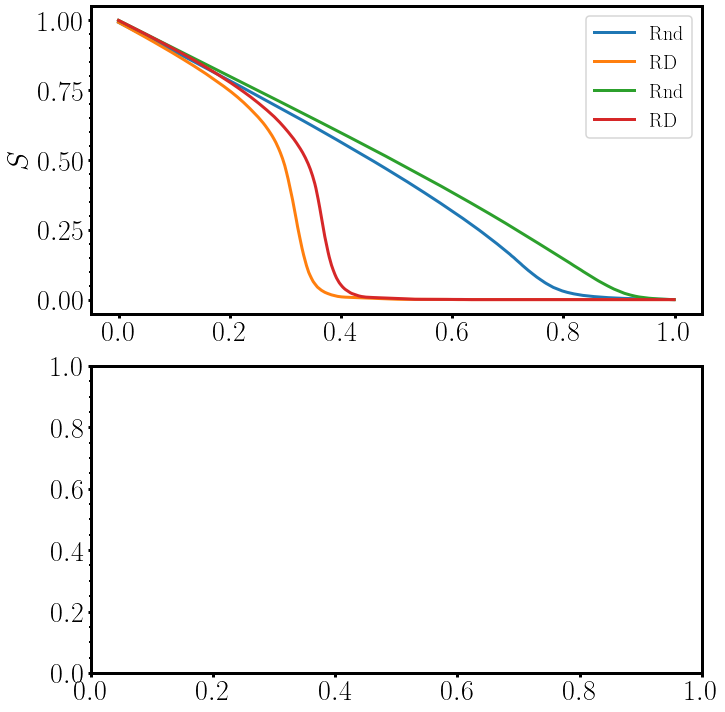

In [83]:
n_seeds = 1000
N = 1000

attacks = [
    'Ran', 
    #'Deg', 
    'DegU', 
    #'CI', 'CIU'
]

fig, axes = plt.subplots(figsize=(10,10), nrows=2)

networks = [('ER', '5.00'), ('BA', 5)]
    
for i, (net_type, param) in enumerate(networks):
    ax = axes[0]
    ax.set_ylabel(r'$S$')
    for attack in attacks:
        df = load_dataframe(attack, N, param, net_type, fast=True, n_seeds=n_seeds)
        ax.plot(df.f, df.Sgcc, label=attack_dict[attack])
    ax.legend(loc='best', fontsize=20)

plt.tight_layout()
plt.show()

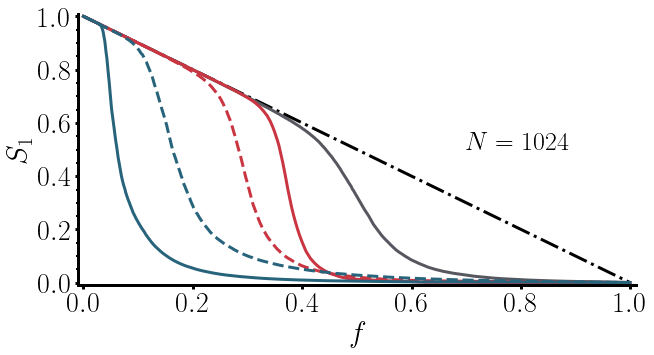

In [42]:
colors = {
    'Btw': '#27647b',
    'BtwU': '#27647b',
    'Deg': '#ca3542',
    'DegU': '#ca3542',
    'Ran': '#57575f'
}

linestyles = {
    'Btw': '--',
    'BtwU': '-',
    'Deg': '--',
    'DegU': '-',
    'Ran': '-'    
}

n_seeds = 1000
N = 1024

attacks = [
    'Ran', 
    #'Deg', 
    'Deg',
    'DegU', 
    #'CI', 'CIU'
    'Btw',
    'BtwU'
]

networks = [
    ('DT', 'param')#, ('BA', 5)
]


fig, ax = plt.subplots(figsize=(10,5), nrows=1)

X = np.linspace(0, 1)
ax.plot(X, 1-X, '-.', color='k', ) 
ax.set_ylabel(r'$S_1$')
ax.set_xlabel(r'$f$')
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-0.01, 1.01)
ax.text(0.7, 0.5, r'$N={{{}}}$'.format(N), fontsize=26)
for i, (net_type, param) in enumerate(networks):
    
    for attack in attacks:
        df = load_dataframe(attack, N, param, net_type, fast=True, n_seeds=n_seeds)
        ax.plot(
            df.f, df.Sgcc, 
            #label=attack_dict[attack], 
            color=colors[attack],
            linestyle=linestyles[attack]
        )
#ax.legend(loc='best', fontsize=20)
sns.despine()
plt.savefig(f'../seminario/DT_S1_N{N}.png')
plt.show()

In [ ]:
colors = {
    'Btw': '#27647b',
    'BtwU': '#27647b',
    'Deg': '#ca3542',
    'DegU': '#ca3542',
    'Ran': '#57575f'
}

linestyles = {
    'Btw': '--',
    'BtwU': '-',
    'Deg': '--',
    'DegU': '-',
    'Ran': '-'    
}

n_seeds = 1000
N = 1024

attacks = [
    'Ran', 
    #'Deg', 
    'Deg',
    'DegU', 
    #'CI', 'CIU'
    'Btw',
    'BtwU'
]

networks = [
    ('DT', 'param')#, ('BA', 5)
]


fig, ax = plt.subplots(figsize=(10,5), nrows=1)

X = np.linspace(0, 1)
ax.plot(X, 1-X, '-.', color='k', ) 
ax.set_ylabel(r'$S_1$')
ax.set_xlabel(r'$f$')
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-0.01, 1.01)
ax.text(0.7, 0.5, r'$N={{{}}}$'.format(N), fontsize=26)
for i, (net_type, param) in enumerate(networks):
    
    for attack in attacks:
        df = load_dataframe(attack, N, param, net_type, fast=True, n_seeds=n_seeds)
        ax.plot(
            df.f, df.Sgcc, 
            #label=attack_dict[attack], 
            color=colors[attack],
            linestyle=linestyles[attack]
        )
#ax.legend(loc='best', fontsize=20)
sns.despine()
plt.savefig(f'../seminario/DT_S1_N{N}.png')
plt.show()

In [102]:
from auxiliary import read_data_file
net_type = 'DT'
param = 'param'
attack = 'Btw'
networks_dir = os.path.join('..', 'networks')
N = 16384
seed = 0

base_net_name, base_net_name_size = get_base_network_name(net_type, N, param)
net_name = base_net_name_size + '_{:05d}'.format(seed)
net_dir = os.path.join(networks_dir, net_type, base_net_name, base_net_name_size, net_name)

DT_base_net_name, DT_base_net_name_size = get_base_network_name('DT', N, param)
DT_net_name = DT_base_net_name_size + '_{:05d}'.format(seed)
DT_net_dir = os.path.join(networks_dir, 'DT', DT_base_net_name, DT_base_net_name_size, DT_net_name)

attack_dir = os.path.join(net_dir, attack)
initial_attack_dir = os.path.join(net_dir, 'Btw')

oi_list = read_data_file(attack_dir, 'oi_list', reader='numpyInt')

g = read_data_file(net_dir, net_name, reader='igraph')
position = read_data_file(DT_net_dir, 'position', reader='numpy')
btw_values = read_data_file(initial_attack_dir, 'initial_centrality', reader='numpy')
norm_btw_values = btw_values / btw_values.max()

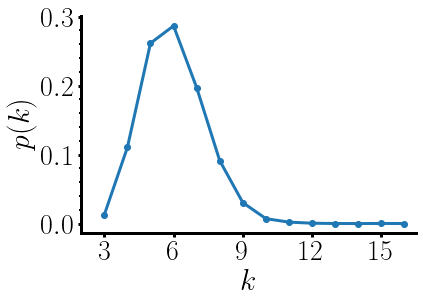

In [136]:
from collections import Counter

X, Y = zip(*sorted(Counter(g.degree()).items(), key=lambda x: x[0]))

X = np.array(X)
Y = np.array(Y) / np.sum(Y)

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlim(2, 16.5)
ax.set_xticks([3, 6, 9, 12, 15])
ax.set_yticks([0, 0.1, 0.2, 0.3])
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$p(k)$')
ax.plot(X, Y, '-o')
sns.despine()
plt.savefig('../seminario/DT_pk.png', transparent=True)
plt.show()

In [115]:
_btw_values.min()

0.7833333329

In [116]:
mask = btw_values > 0
_btw_values = btw_values[mask]
bins = np.logspace(np.log10(_btw_values.min()), np.log10(_btw_values.max()), 10)
freq, bin_edges = np.histogram(_btw_values, bins=bins, density=True)
bin_centers = bin_edges[:-1]

In [121]:
bin_edges

array([7.83333333e-01, 5.55827496e+00, 3.94396858e+01, 2.79851002e+02,
       1.98573040e+03, 1.40900880e+04, 9.99786168e+04, 7.09415288e+05,
       5.03377689e+06, 3.57180205e+07])

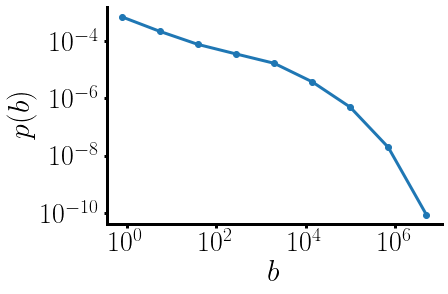

In [135]:
from collections import Counter

X = bin_centers
Y = freq

fig, ax = plt.subplots(figsize=(6, 4))

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([1, 100, 10000,  1000000])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())

#ax.set_yscale('log')
#ax.set_ylim(0.05, 0.4)
#ax.set_yticks([0.1, 0.3])
ax.set_yticks([1e-10, 1e-8, 1e-6, 1e-4])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())


ax.set_xlabel(r'$b$')
ax.set_ylabel(r'$p(b)$')

ax.plot(X, Y, '-o')
sns.despine()
plt.savefig('../seminario/DT_pb.png', transparent=True)
plt.show()